>>> Trainable parameter in tensor_fusion model: 223466
>>> tensor_fusion model loaded!
>>> tensor_fusion model test loss: 0.5597, test acc: 0.9811

>>> Trainable parameter in efficient_tensor_fusion model: 169098
>>> efficient_tensor_fusion model loaded!
>>> efficient_tensor_fusion model test loss: 0.5596, test acc: 0.9804

>>> Trainable parameter in multi_concat model: 223434
>>> multi_concat model loaded!
>>> multi_concat model test loss: 0.5900, test acc: 0.9741

>>> Trainable parameter in multiplication model: 136298
>>> multiplication model loaded!
>>> multiplication model test loss: 0.5448, test acc: 0.9853

>>> Trainable parameter in concat model: 238058
>>> concat model loaded!
>>> concat model test loss: 0.5456, test acc: 0.9871

>>> Trainable parameter in concat model: 63210
>>> concat model loaded!
>>> concat model test loss: 0.5527, test acc: 0.9837

>>> tensor_fusion model radius history loaded!
>>> efficient_tensor_fusion model radius history loaded!
>>> multi_concat mode

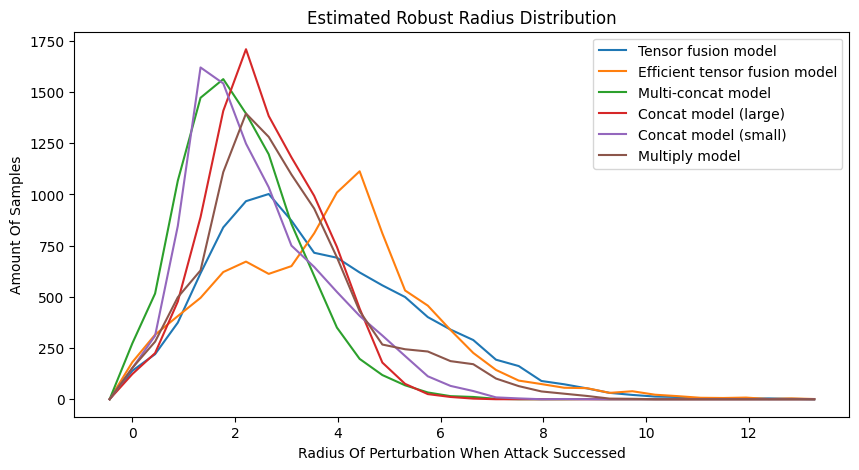

>>> Tensor fusion model radius history statistics:
 - Mean: 3.8187
 - Std: 1.9930
 - Median: 3.4708
 - Max: 13.0784
 - Min: 0.0140

>>> Efficient tensor fusion model radius history statistics:
 - Mean: 3.9739
 - Std: 1.9770
 - Median: 4.0450
 - Max: 13.3234
 - Min: 0.0147

>>> Multi-concat model radius history statistics:
 - Mean: 2.3254
 - Std: 1.1346
 - Median: 2.2051
 - Max: 9.0409
 - Min: 0.0154

>>> Concat model (large) radius history statistics:
 - Mean: 2.7763
 - Std: 1.0922
 - Median: 2.6868
 - Max: 6.6924
 - Min: 0.0147

>>> Concat model (small) radius history statistics:
 - Mean: 2.6433
 - Std: 1.3395
 - Median: 2.3556
 - Max: 8.6195
 - Min: 0.0149

>>> Multiply model radius history statistics:
 - Mean: 3.2000
 - Std: 1.5999
 - Median: 2.9419
 - Max: 10.0894
 - Min: 0.0152

>>> Tensor fusion model attack success example:
 - Index 0 	 attack success at iter: 3051, 	 radius: 2.7542
 - Prediction of original image: 1
 - Prediction of perturbed image: 7


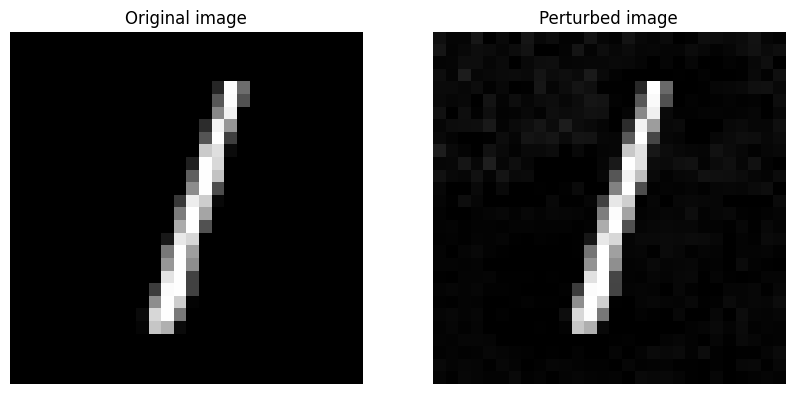


>>> Efficient tensor fusion model attack success example:
 - Index 0 	 attack success at iter: 4679, 	 radius: 4.5114
 - Prediction of original image: 2
 - Prediction of perturbed image: 7


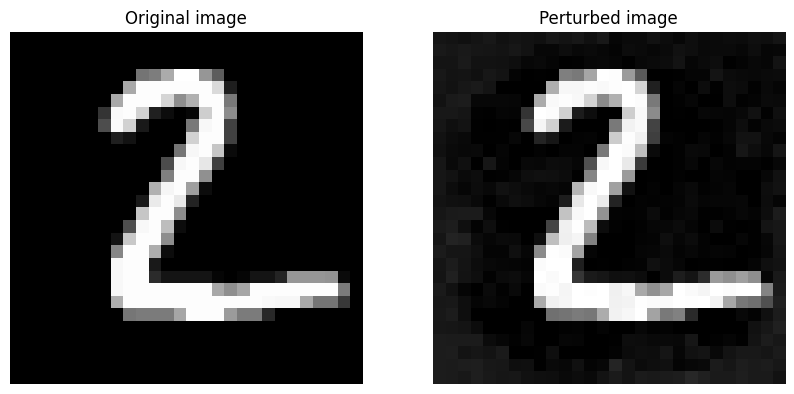


>>> Multi-concat model attack success example:
 - Index 0 	 attack success at iter: 2996, 	 radius: 2.0436
 - Prediction of original image: 1
 - Prediction of perturbed image: 8


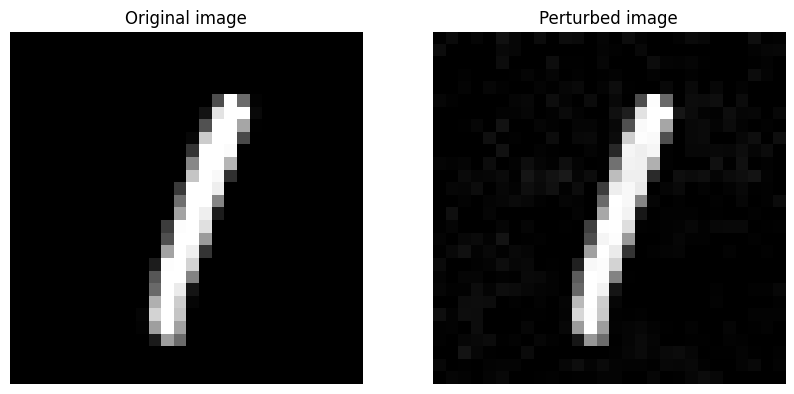


>>> Concat model (large) attack success example:
 - Index 0 	 attack success at iter: 3021, 	 radius: 2.3867
 - Prediction of original image: 1
 - Prediction of perturbed image: 8


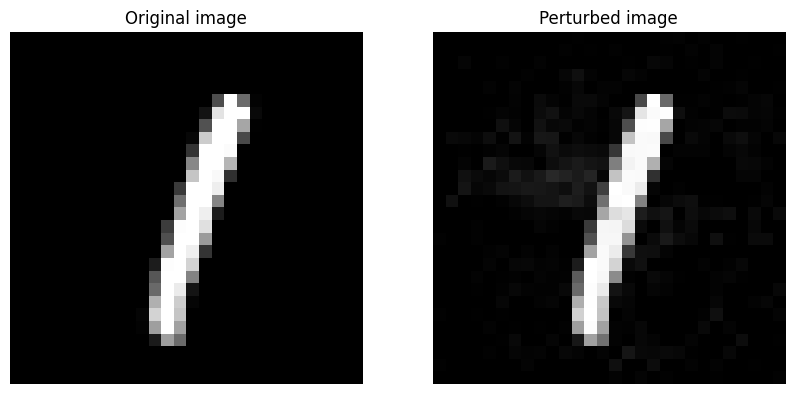


>>> Concat model (small) attack success example:
 - Index 0 	 attack success at iter: 1716, 	 radius: 1.3302
 - Prediction of original image: 1
 - Prediction of perturbed image: 8


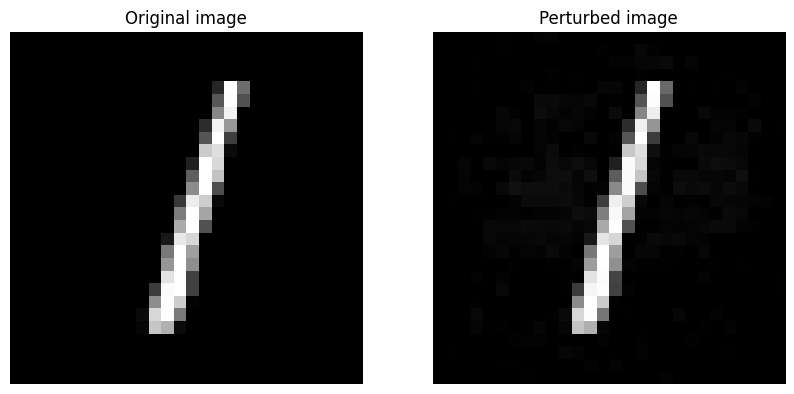


>>> Multiply model attack success example:
 - Index 0 	 attack success at iter: 2724, 	 radius: 2.4160
 - Prediction of original image: 7
 - Prediction of perturbed image: 2


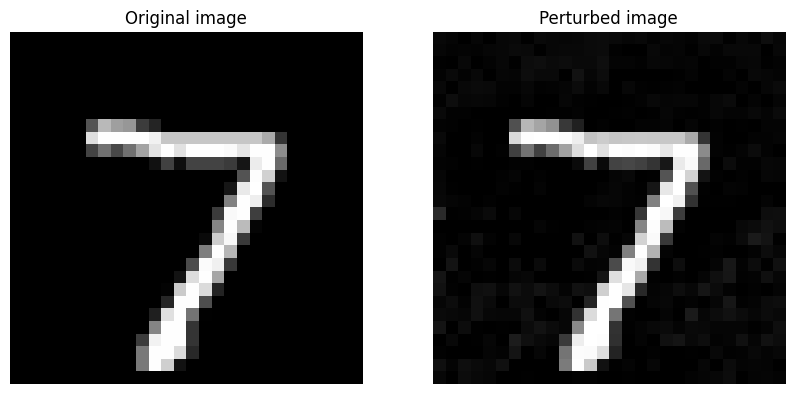

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

from model import SimpleNet, ModelType
from trainer import Train, Validate
from attacker import Attack
    


def GetDigitImg(img_tensor):
    # reverse normalization
    img_tensor = img_tensor * 0.3081 + 0.1307
    img_tensor = img_tensor.clamp(0, 1)

    # convert to numpy and return
    return img_tensor.squeeze(0).numpy()



def TrainAndEval(model_type: ModelType, file_pre, emb_len):
    # create model
    model = SimpleNet(model_type=model_type, emb_len=emb_len).to(device)

    # print trainable parameter amount
    print('>>> Trainable parameter in {} model: {}'.format(model_type, sum(p.numel() for p in model.parameters() if p.requires_grad)))

    # check if model exists
    if os.path.exists(save_path + '{}_model.pth'.format(file_pre)):
        model.load_state_dict(torch.load(save_path + '{}_model.pth'.format(file_pre)))
        print('>>> {} model loaded!'.format(model_type))
    else:
        print('>>> {} model training...'.format(model_type))
        # train model
        model, history = Train(
            model,
            train_loader,
            epochs=epochs,
            lr=lr,
            weight_decay=weight_decay,
            device=device,
            val_freq=val_freq,
            val_loader=val_loader
        )
        print('>>> {} model training finished!'.format(model_type))

        # save model
        torch.save(model.state_dict(), save_path + '{}_model.pth'.format(file_pre))

    # evaluate model
    model.eval()
    loss_test, acc_test = Validate(model, test_loader, torch.nn.CrossEntropyLoss(label_smoothing=0.1), device=device)
    loss_test, acc_test = sum(loss_test) / len(loss_test), sum(acc_test) / len(acc_test)
    print('>>> {} model test loss: {:.4f}, test acc: {:.4f}'.format(
        model_type,
        loss_test,
        acc_test
    ))

    print()

    return model, loss_test, acc_test


def GetRadiusHis(file_pre, model: SimpleNet):
    model_type = model.model_type
    # check if radius history exists
    if os.path.exists(save_path + '{}_radius_his.npy'.format(file_pre)):
        radius_his = np.load(save_path + '{}_radius_his.npy'.format(file_pre))
        print('>>> {} model radius history loaded!'.format(model_type))
    else:
        # certify model
        print('>>> Certifying {} model...'.format(model_type))
        radius_his, _ = Attack(model, test_loader_one, upper_bound, lower_bound, device=device)
        radius_his = np.array(radius_his)

        # save radius history
        np.save(save_path + '{}_radius_his.npy'.format(file_pre), radius_his)
    
    return radius_his



cudnn.deterministic = True # For reproducibility

# parameters
val_ratio = 0.1
lr = 4e-5
epochs = 500
weight_decay = 1e-4
val_freq = 0.5
patience = 10

train_batch_size = 32
val_batch_size = 256

# constant
save_path = './output/'

# create save path if not exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# set random seed
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# load data
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# split train and validation
train_set, val_set = torch.utils.data.random_split(
    train_set,
    [
        len(train_set) - int(len(train_set) * val_ratio),
        int(len(train_set) * val_ratio)
    ]
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=val_batch_size, shuffle=False, num_workers=16, pin_memory=True)

# train and evaluate models
tf_model, loss_tf_test, acc_tf_test = TrainAndEval(ModelType.TF, file_pre='tf', emb_len=8)
etf_model, loss_etf_test, acc_etf_test = TrainAndEval(ModelType.ETF, file_pre='etf', emb_len=16)
multi_concat_model, loss_multi_concat_test, acc_multi_concat_test = TrainAndEval(ModelType.MULTI_CONCAT, file_pre='multi_concat', emb_len=8)
multiply_model, loss_multiply_test, acc_multiply_test = TrainAndEval(ModelType.MULTIPLY, file_pre='multiply', emb_len=64)
concat_large_model, loss_concat_large_test, acc_concat_large_test = TrainAndEval(ModelType.CONCAT, file_pre='concat_large', emb_len=96)
concat_small_model, loss_concat_small_test, acc_concat_small_test = TrainAndEval(ModelType.CONCAT, file_pre='concat_small', emb_len=32)

test_loader_one = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=16, pin_memory=True)

# robustness certification
# find upper bound and lower bound by apply transform to 255 and 0
upper_bound = transform(torch.ones(1,1).numpy()).cpu().item()
lower_bound = transform(torch.zeros(1,1).numpy()).cpu().item()

# get radius history
tf_radius_his = GetRadiusHis('tf', tf_model)
etf_radius_his = GetRadiusHis('etf', etf_model)
multi_concat_radius_his = GetRadiusHis('multi_concat', multi_concat_model)
multiply_radius_his = GetRadiusHis('multiply', multiply_model)
concat_large_radius_his = GetRadiusHis('concat_large', concat_large_model)
concat_small_radius_his = GetRadiusHis('concat_small', concat_small_model)

# get rid of attack failed and misclassified
tf_radius_his = tf_radius_his[tf_radius_his > 0]
etf_radius_his = etf_radius_his[etf_radius_his > 0]
multiply_radius_his = multiply_radius_his[multiply_radius_his > 0]
multi_concat_radius_his = multi_concat_radius_his[multi_concat_radius_his > 0]
concat_large_radius_his = concat_large_radius_his[concat_large_radius_his > 0]
concat_small_radius_his = concat_small_radius_his[concat_small_radius_his > 0]

# find max and min radius
max_radius = max([his.max() for his in [tf_radius_his, etf_radius_his, multi_concat_radius_his, concat_large_radius_his, concat_small_radius_his, multiply_radius_his]])
min_radius = min([his.min() for his in [tf_radius_his, etf_radius_his, multi_concat_radius_his, concat_large_radius_his, concat_small_radius_his, multiply_radius_his]])

# set interval of datapoints
interval_num = 30
interval = (max_radius - min_radius) / interval_num // 0.0025 * 0.0025 # divide into 30 intervals, and round to 0.0025

# find rounded max and min radius
if max_radius % interval != 0:
    max_radius = (max_radius // interval + 1) * interval
if min_radius % interval != 0:
    min_radius = (min_radius // interval - 1) * interval

# count radius in each interval range
tf_radius_count = np.zeros(int((max_radius - min_radius) / interval))
etf_radius_count = np.zeros(int((max_radius - min_radius) / interval))
multi_concat_radius_count = np.zeros(int((max_radius - min_radius) / interval))
multiply_radius_count = np.zeros(int((max_radius - min_radius) / interval))
concat_large_radius_count = np.zeros(int((max_radius - min_radius) / interval))
concat_small_radius_count = np.zeros(int((max_radius - min_radius) / interval))

for radius in tf_radius_his:
    tf_radius_count[int((radius - min_radius) / interval)] += 1
for radius in etf_radius_his:
    etf_radius_count[int((radius - min_radius) / interval)] += 1
for radius in multi_concat_radius_his:
    multi_concat_radius_count[int((radius - min_radius) / interval)] += 1
for radius in multiply_radius_his:
    multiply_radius_count[int((radius - min_radius) / interval)] += 1
for radius in concat_large_radius_his:
    concat_large_radius_count[int((radius - min_radius) / interval)] += 1
for radius in concat_small_radius_his:
    concat_small_radius_count[int((radius - min_radius) / interval)] += 1

# plot radius figure
plt.figure(figsize=(10, 5))
count_list = [tf_radius_count, etf_radius_count, multi_concat_radius_count, concat_large_radius_count, concat_small_radius_count, multiply_radius_count]
name_list = [
    'Tensor fusion model',
    'Efficient tensor fusion model',
    'Multi-concat model',
    'Concat model (large)',
    'Concat model (small)',
    'Multiply model'
]
for i, (count, name) in enumerate(zip(count_list, name_list)):
    plt.plot(np.arange(min_radius, max_radius, interval), count, label=name)
plt.legend()
plt.xlabel('Radius Of Perturbation When Attack Successed')
plt.ylabel('Amount Of Samples')
plt.title('Estimated Robust Radius Distribution')
plt.show()

# print satatistics of radius history (mean, std, median, max, min)
for his, name in zip([tf_radius_his, etf_radius_his, multi_concat_radius_his, concat_large_radius_his, concat_small_radius_his, multiply_radius_his], name_list):
    print('>>> {} radius history statistics:'.format(name))
    print(' - Mean: {:.4f}'.format(his.mean()))
    print(' - Std: {:.4f}'.format(his.std()))
    print(' - Median: {:.4f}'.format(np.median(his)))
    print(' - Max: {:.4f}'.format(his.max()))
    print(' - Min: {:.4f}'.format(his.min()))
    print()

# show example of attack success
for model, count, his, name in zip(
        [tf_model, etf_model, multi_concat_model, concat_large_model, concat_small_model, multiply_model],
        [tf_radius_count, etf_radius_count, multi_concat_radius_count, concat_large_radius_count, concat_small_radius_count, multiply_radius_count],
        [tf_radius_his, etf_radius_his, multi_concat_radius_his, concat_large_radius_his, concat_small_radius_his, multiply_radius_his],
        name_list
    ):
    print('>>> {} attack success example:'.format(name))
    # find most occured radius range
    radius_index = np.argmax(count)
    radius_lower = min_radius + radius_index * interval
    radius_upper = radius_lower + interval
    # find first attack success index
    attack_index = np.where((his > radius_lower) & (his < radius_upper))[0][0]
    # show example
    original_img = test_set[attack_index][0]
    test_loader_single_shot = torch.utils.data.DataLoader(
        torch.utils.data.Subset(test_set, [attack_index]),
        batch_size=1,
        shuffle=False,
        num_workers=16,
        pin_memory=True
    )
    radius, pert = Attack(
        model,
        test_loader_single_shot,
        upper_bound,
        lower_bound,
        device=device,
    )
    radius = radius[0]
    pert = pert[0]
    # print prediction of original image and perturbed image
    print(' - Prediction of original image: {}'.format(model(test_set[attack_index][0].unsqueeze(0).to(device)).argmax(dim=1).item()))
    print(' - Prediction of perturbed image: {}'.format(model(test_set[attack_index][0].unsqueeze(0).to(device) + torch.tensor(pert).unsqueeze(0).to(device)).argmax(dim=1).item()))
    # plot original image and perturbed image side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GetDigitImg(original_img), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(GetDigitImg(original_img + np.expand_dims(pert, axis=0).reshape(28, 28)), cmap='gray')
    plt.title('Perturbed image')
    plt.axis('off')
    plt.show()
    print()